# LeakyBucket model BMI demo

In this notebook we demonstrate the leakybucket Basic Model Interface. This BMI has the following model structure implemented:

<img src="diagram.png" alt="diagram" width="200"/>

The implementation can be found in `src/leakybucket/leakybucket_bmi.py`

To be able to initialize the BMI, we need a configuration file which contains the "leakiness" parameter, as well as the forcing file locations.

For forcing we use the eWaterCycle generic forcing generator. This can generate forcing data with ESMValTool from ERA5 data (if available on your machine), as well as CMIP6 data (which will be downloaded automatically).

In [15]:
from leakybucket.leakybucket_bmi import LeakyBucketBmi
from ewatercycle.base.forcing import GenericLumpedForcing
import ewatercycle.observation.grdc
import ewatercycle.analysis
from pathlib import Path
import pandas as pd
import numpy as np

shape = Path(ewatercycle.__file__).parent / "testing/data/Rhine/Rhine.shp"


grdc_station_id = "6335020"  # GRDC station ID
basin_name = "Rhine"

experiment_start_time="2000-01-01T00:00:00Z"
experiment_end_time="2000-12-31T00:00:00Z"


TEXT ABOUT CREATING FORCING

In [8]:
ERA5_forcing = GenericLumpedForcing.generate(
    dataset="ERA5",
    start_time=experiment_start_time,
    end_time=experiment_end_time,
    shape=shape.absolute(),
)

{'diagnostic': 'diagnostic',
 'variable_group': 'pr',
 'dataset': 'ERA5',
 'project': 'OBS6',
 'mip': 'day',
 'short_name': 'pr',
 'alias': 'ERA5',
 'frequency': 'day',
 'long_name': 'Precipitation',
 'modeling_realm': ['atmos'],
 'original_short_name': 'pr',
 'preprocessor': 'pr',
 'recipe_dataset_index': 0,
 'standard_name': 'precipitation_flux',
 'tier': 3,
 'timerange': '2000/2000',
 'type': 'reanaly',
 'units': 'kg m-2 s-1',
 'version': 1}
session: 'ewcrep4xt_3p6h_20240324_151057'.
{'diagnostic': 'diagnostic',
 'variable_group': 'tas',
 'dataset': 'ERA5',
 'project': 'OBS6',
 'mip': 'day',
 'short_name': 'tas',
 'alias': 'ERA5',
 'frequency': 'day',
 'long_name': 'Near-Surface Air Temperature',
 'modeling_realm': ['atmos'],
 'original_short_name': 'tas',
 'preprocessor': 'tas',
 'recipe_dataset_index': 0,
 'standard_name': 'air_temperature',
 'tier': 3,
 'timerange': '2000/2000',
 'type': 'reanaly',
 'units': 'K',
 'version': 1}
session: 'ewcrep4xt_3p6h_20240324_151057'.
{'diagnos

Now we have the forcing data available we can prepare the configuration file:

In [9]:
experiment_config_file = f"""{{
    "precipitation_file": "{ERA5_forcing.directory / ERA5_forcing.pr}",
    "temperature_file": "{ERA5_forcing.directory / ERA5_forcing.tas}",
    "leakiness": 0.05
}}
"""

with open("ERA5_leakybucket_config.json", "w") as f:
    f.write(experiment_config_file)

With the configuration file ready, we can define the model and initialize it. To clearly indicate that we are creating an instance of the class ```LeakyBucketBMI``` we use ```experiment_model``` as the name for the model object for this (demo) experiment.

In [47]:
experiment_model = LeakyBucketBmi()
experiment_model.initialize(config_file="ERA5_leakybucket_config.json")

We can now use the `.update()` method to advance the model one time step.
After updating the model, we can request the current discharge using `.get_value("discharge")`.

We store this discharge in a list. For plotting, we also request the current model time (which is in seconds since 1970), and covert that to a pandas Timestamp.

In [48]:
discharge = []
time = []
while experiment_model.get_current_time() < experiment_model.get_end_time():
    experiment_model.update()
    discharge.append(experiment_model.get_value("discharge", np.array([0.])))
    time.append(pd.Timestamp(experiment_model.get_current_time(), unit="s"))

We can plot the output discharge directly

Text(0.5, 0, 'Time')

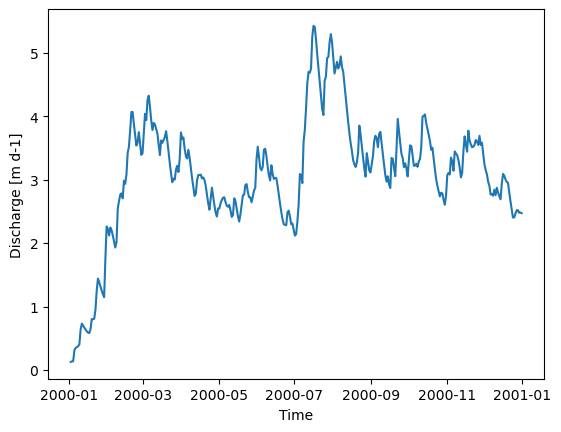

In [49]:
import matplotlib.pyplot as plt
plt.plot(time, discharge)

plt.ylabel(f"Discharge [{experiment_model.get_var_units('discharge')}]")
plt.xlabel("Time")

Now we can plot our hydrograph.

Note that the unit of discharge is in mm/d. Conversion to m3/s requires the area of the catchment.

In [52]:
discharge_dataframe = pd.DataFrame({'model output': discharge}, index=pd.to_datetime(time))
discharge_dataframe

,model output
2000-01-02 12:00:00,[0.12751837202813476]
2000-01-03 12:00:00,[0.13580070866737515]
2000-01-04 12:00:00,[0.13741430452500936]
2000-01-05 12:00:00,[0.3118573878287862]
2000-01-06 12:00:00,[0.34970944125172543]
...,...
2000-12-27 12:00:00,[2.516473100053885]
2000-12-28 12:00:00,[2.518817645077457]
2000-12-29 12:00:00,[2.4784821012140354]
2000-12-30 12:00:00,[2.480762512717364]


In [25]:

observations_df, metadata = ewatercycle.observation.grdc.get_grdc_data(
    station_id=grdc_station_id,
    start_time=experiment_start_time,
    end_time=experiment_end_time,
)
grdc_obs = observations_df.rename(columns={"streamflow": "Observations from GRDC"})
grdc_lon = metadata["grdc_longitude_in_arc_degree"]
grdc_lat = metadata["grdc_latitude_in_arc_degree"]

In [26]:
hydro_data = pd.concat([discharge_dataframe, grdc_obs], axis=1)
hydro_data

,model output,Observations from GRDC
2000-01-01 00:00:00,NaN,6010.0
2000-01-02 00:00:00,NaN,5330.0
2000-01-02 12:00:00,[0.12751837202813476],NaN
2000-01-03 00:00:00,NaN,4700.0
2000-01-03 12:00:00,[0.13580070866737515],NaN
...,...,...
2000-12-29 12:00:00,[2.4784821012140354],NaN
2000-12-30 00:00:00,NaN,2300.0
2000-12-30 12:00:00,[2.480762512717364],NaN
2000-12-31 00:00:00,NaN,2210.0


TypeError: no numeric data to plot

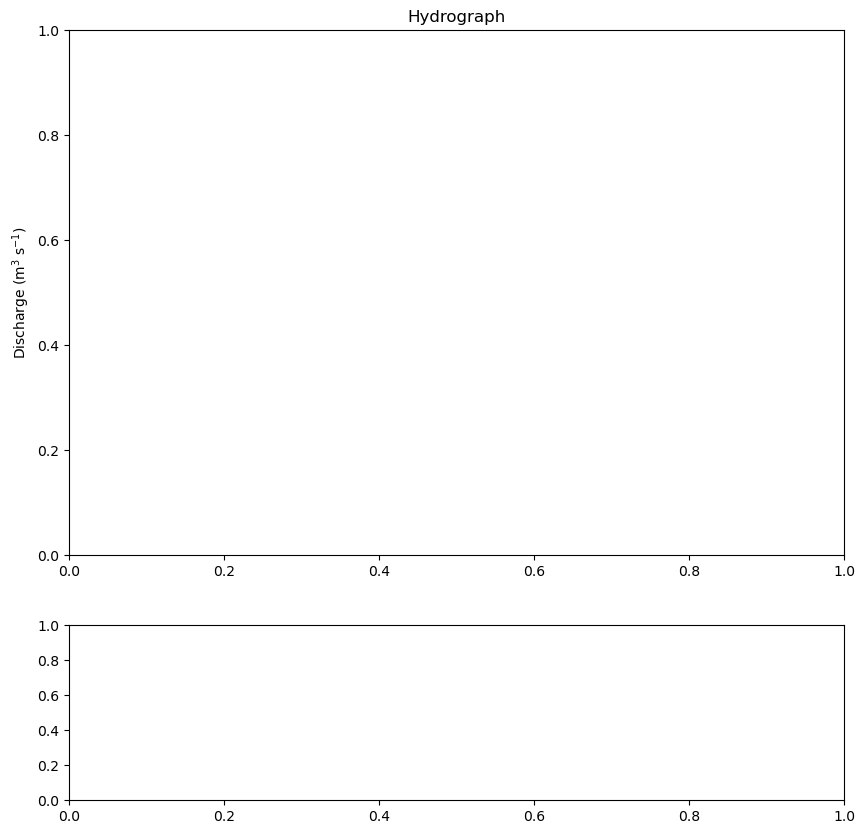

In [27]:


# Plot hydrograph and show metrics
ewatercycle.analysis.hydrograph(hydro_data, reference='Observations from GRDC', filename = 'experiment_hydrograph.png')

It is good practice to remove a model object when done using ```.finalize()```. For small models like this, it doesn't matter too much, but larger models that run in containers keep using resources when not ```finalized```.

In [28]:
experiment_model.finalize()